In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import  SubsetRandomSampler 
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import cv2
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [2]:
from tensorflow import keras
from keras.datasets import fashion_mnist

print("[INFO] loading Fashion MNIST...")

((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

X_train, X_val, Y_train, Y_val = train_test_split(trainX,trainY, test_size=0.2)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

Using TensorFlow backend.


[INFO] loading Fashion MNIST...
(48000, 28, 28)
(48000,)
(12000, 28, 28)
(12000,)


In [3]:
#normalization
X_train = X_train.astype('float32')/ 255
testX = testX.astype('float32') / 255
X_val = X_val.astype('float32')/ 255

X_train = torch.from_numpy(X_train).cuda()
Y_train = torch.from_numpy(Y_train).type(torch.LongTensor).cuda() # data type is long

X_val = torch.from_numpy(X_val).cuda()
Y_val = torch.from_numpy(Y_val).type(torch.LongTensor).cuda() # data type is long

X_test = torch.from_numpy(testX).cuda()
Y_test = torch.from_numpy(testY).type(torch.LongTensor).cuda() # data type is long


# Pytorch train and test TensorDataset
train = torch.utils.data.TensorDataset(X_train.unsqueeze(1),Y_train)
val = torch.utils.data.TensorDataset(X_val.unsqueeze(1),Y_val)
test = torch.utils.data.TensorDataset(X_test.unsqueeze(1),Y_test)

# Pytorch DataLoader
train_loader = torch.utils.data.DataLoader(train, batch_size = 64, shuffle = True)
valid_loader = torch.utils.data.DataLoader(val, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 64, shuffle = True)

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  del sys.path[0]


C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


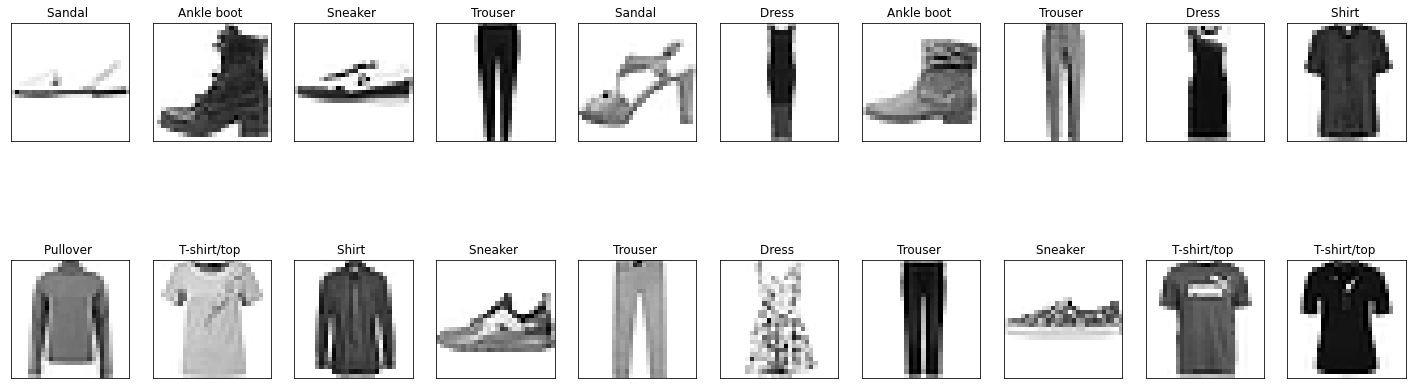

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images=images.squeeze(1)

classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'] 

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].cpu().numpy(),cmap=plt.cm.binary)
    ax.set_title("{} ".format( classes[labels[idx]]))

In [5]:
# 3,1
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()

        # Convolution 1 , input_shape=(1,28,28)  #out_channel==幾個filter=幾個feature map
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0) #output_shape=(16,26,26)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,ceil_mode=True) #output_shape=(16,13,13)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0) #output_shape=(32,11,11)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,ceil_mode=True) #output_shape=(32,6,6)
        # Fully connected 1 ,#input_shape=(32*6*6)
        self.fc1 = nn.Linear(32 * 6 * 6, 10) 
      
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2 
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out 

In [6]:
def fit_model(model, criterion, optimizer,epochs,train_loader,test_loader):
    valid_loss_min = np.Inf
    steps = 0
    model.train() #prep model for training
    train_losses, valid_losses = [],[]
    training_accuracy, validation_accuracy = [],[]


    for e in range(epochs):
        running_loss =0 
        valid_loss = 0

        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images=images.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*images.size(0)


            predicted = torch.max(log_ps.data, 1)[1]
            total_train += len(labels)
            correct_train += (predicted == labels).float().sum()

        correct_test = 0
        total_test = 0

        for images, labels in valid_loader:
            images=images.to(device)
            labels=labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            valid_loss += loss.item()*images.size(0)

            predicted = torch.max(log_ps.data, 1)[1]
            total_test += len(labels)  
            correct_test += (predicted == labels).float().sum()

        train_accuracy = 1 * correct_train / float(total_train)
        val_accuracy = 1 * correct_test / float(total_test)
        running_loss = running_loss/len(train_loader.sampler)
        valid_loss =  valid_loss/len(valid_loader.sampler)

        train_losses.append(running_loss)
        valid_losses.append(valid_loss)
        training_accuracy.append(train_accuracy)
        validation_accuracy.append(val_accuracy)

        print('Epoch: {} \tTraining Loss: {:.6f} Validation Loss: {:.6f} Training acc: {:.6f} Validation acc: {:.6f}'.format(
            e+1,
            running_loss,
            valid_loss,
            train_accuracy,
            val_accuracy
        ))
    return train_losses, training_accuracy, valid_losses, validation_accuracy       

In [7]:
model = CNN_Model().cuda()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
criterion =nn.CrossEntropyLoss() 
epochs = 20
training_loss, training_accuracy, validation_loss, validation_accuracy=fit_model(model, criterion, optimizer,epochs,train_loader,test_loader)

CNN_Model(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (fc1): Linear(in_features=1152, out_features=10, bias=True)
)
Epoch: 1 	Training Loss: 0.604061 Validation Loss: 0.419186 Training acc: 0.783917 Validation acc: 0.848167
Epoch: 2 	Training Loss: 0.402074 Validation Loss: 0.359034 Training acc: 0.856229 Validation acc: 0.872083
Epoch: 3 	Training Loss: 0.353074 Validation Loss: 0.319258 Training acc: 0.874104 Validation acc: 0.885250
Epoch: 4 	Training Loss: 0.323962 Validation Loss: 0.317109 Training acc: 0.883917 Validation acc: 0.886500
Epoch: 5 	Training Loss: 0.304707 Validation Loss: 0.290780 Training acc: 0.890604 Validation acc: 0.895833
Epoch: 6 	Training Loss: 0.285438 Validation Loss: 0.3

In [8]:
torch.save(model,'model_3_1.pt')

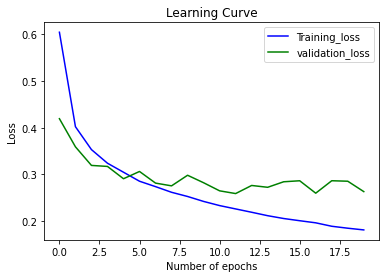

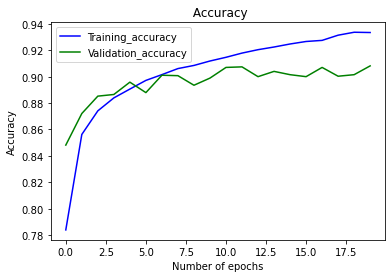

In [8]:
training_accuracy = [training_accuracy[a].cpu().numpy() for a in range(len(training_accuracy))]
validation_accuracy = [validation_accuracy[a].cpu().numpy() for a in range(len(validation_accuracy))]

plt.plot(range(epochs), training_loss, 'b-', label='Training_loss')
plt.plot(range(epochs), validation_loss, 'g-', label='validation_loss')
plt.title('Learning Curve')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(range(epochs), training_accuracy, 'b-', label='Training_accuracy')
plt.plot(range(epochs), validation_accuracy, 'g-', label='Validation_accuracy')
plt.title(' Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
print(np.mean(training_loss))
print(np.mean(validation_loss))

print(np.mean(training_accuracy))
print(np.mean(validation_accuracy))


0.2676615049010763
0.29439245112240314
0.9033375
0.89534587


In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [11]:
use_cuda = torch.cuda.is_available()
model.cuda()
test(test_loader, model, criterion, use_cuda)

Test Loss: 0.295998
Test Accuracy: 89% (8989/10000)


In [12]:
no_of_layers=0
conv_layers=[]
 
model_children=list(model.children())
 
for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

2


Text(0.5, 1.0, 'true=Ankle boot , pred=Ankle boot ')

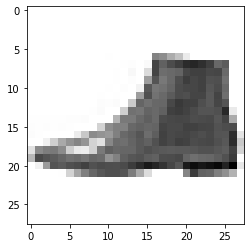

In [29]:
for images, labels in test_loader:
    images=images.to(device)
    labels=labels.to(device)

img=images
img = img.to('cuda')

results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

#fig = plt.figure(figsize=(25, 8))
picture=img[0:1,:,:,:]

ps = torch.exp(model(picture))
ps = ps.squeeze().cpu().detach().numpy()
pred=np.argmax(ps)


plt.imshow(picture.squeeze().cpu().numpy(),cmap=plt.cm.binary)
ax.set_title("true={} , pred={} ".format(classes[labels[0]],classes[pred]) )


Layer  1


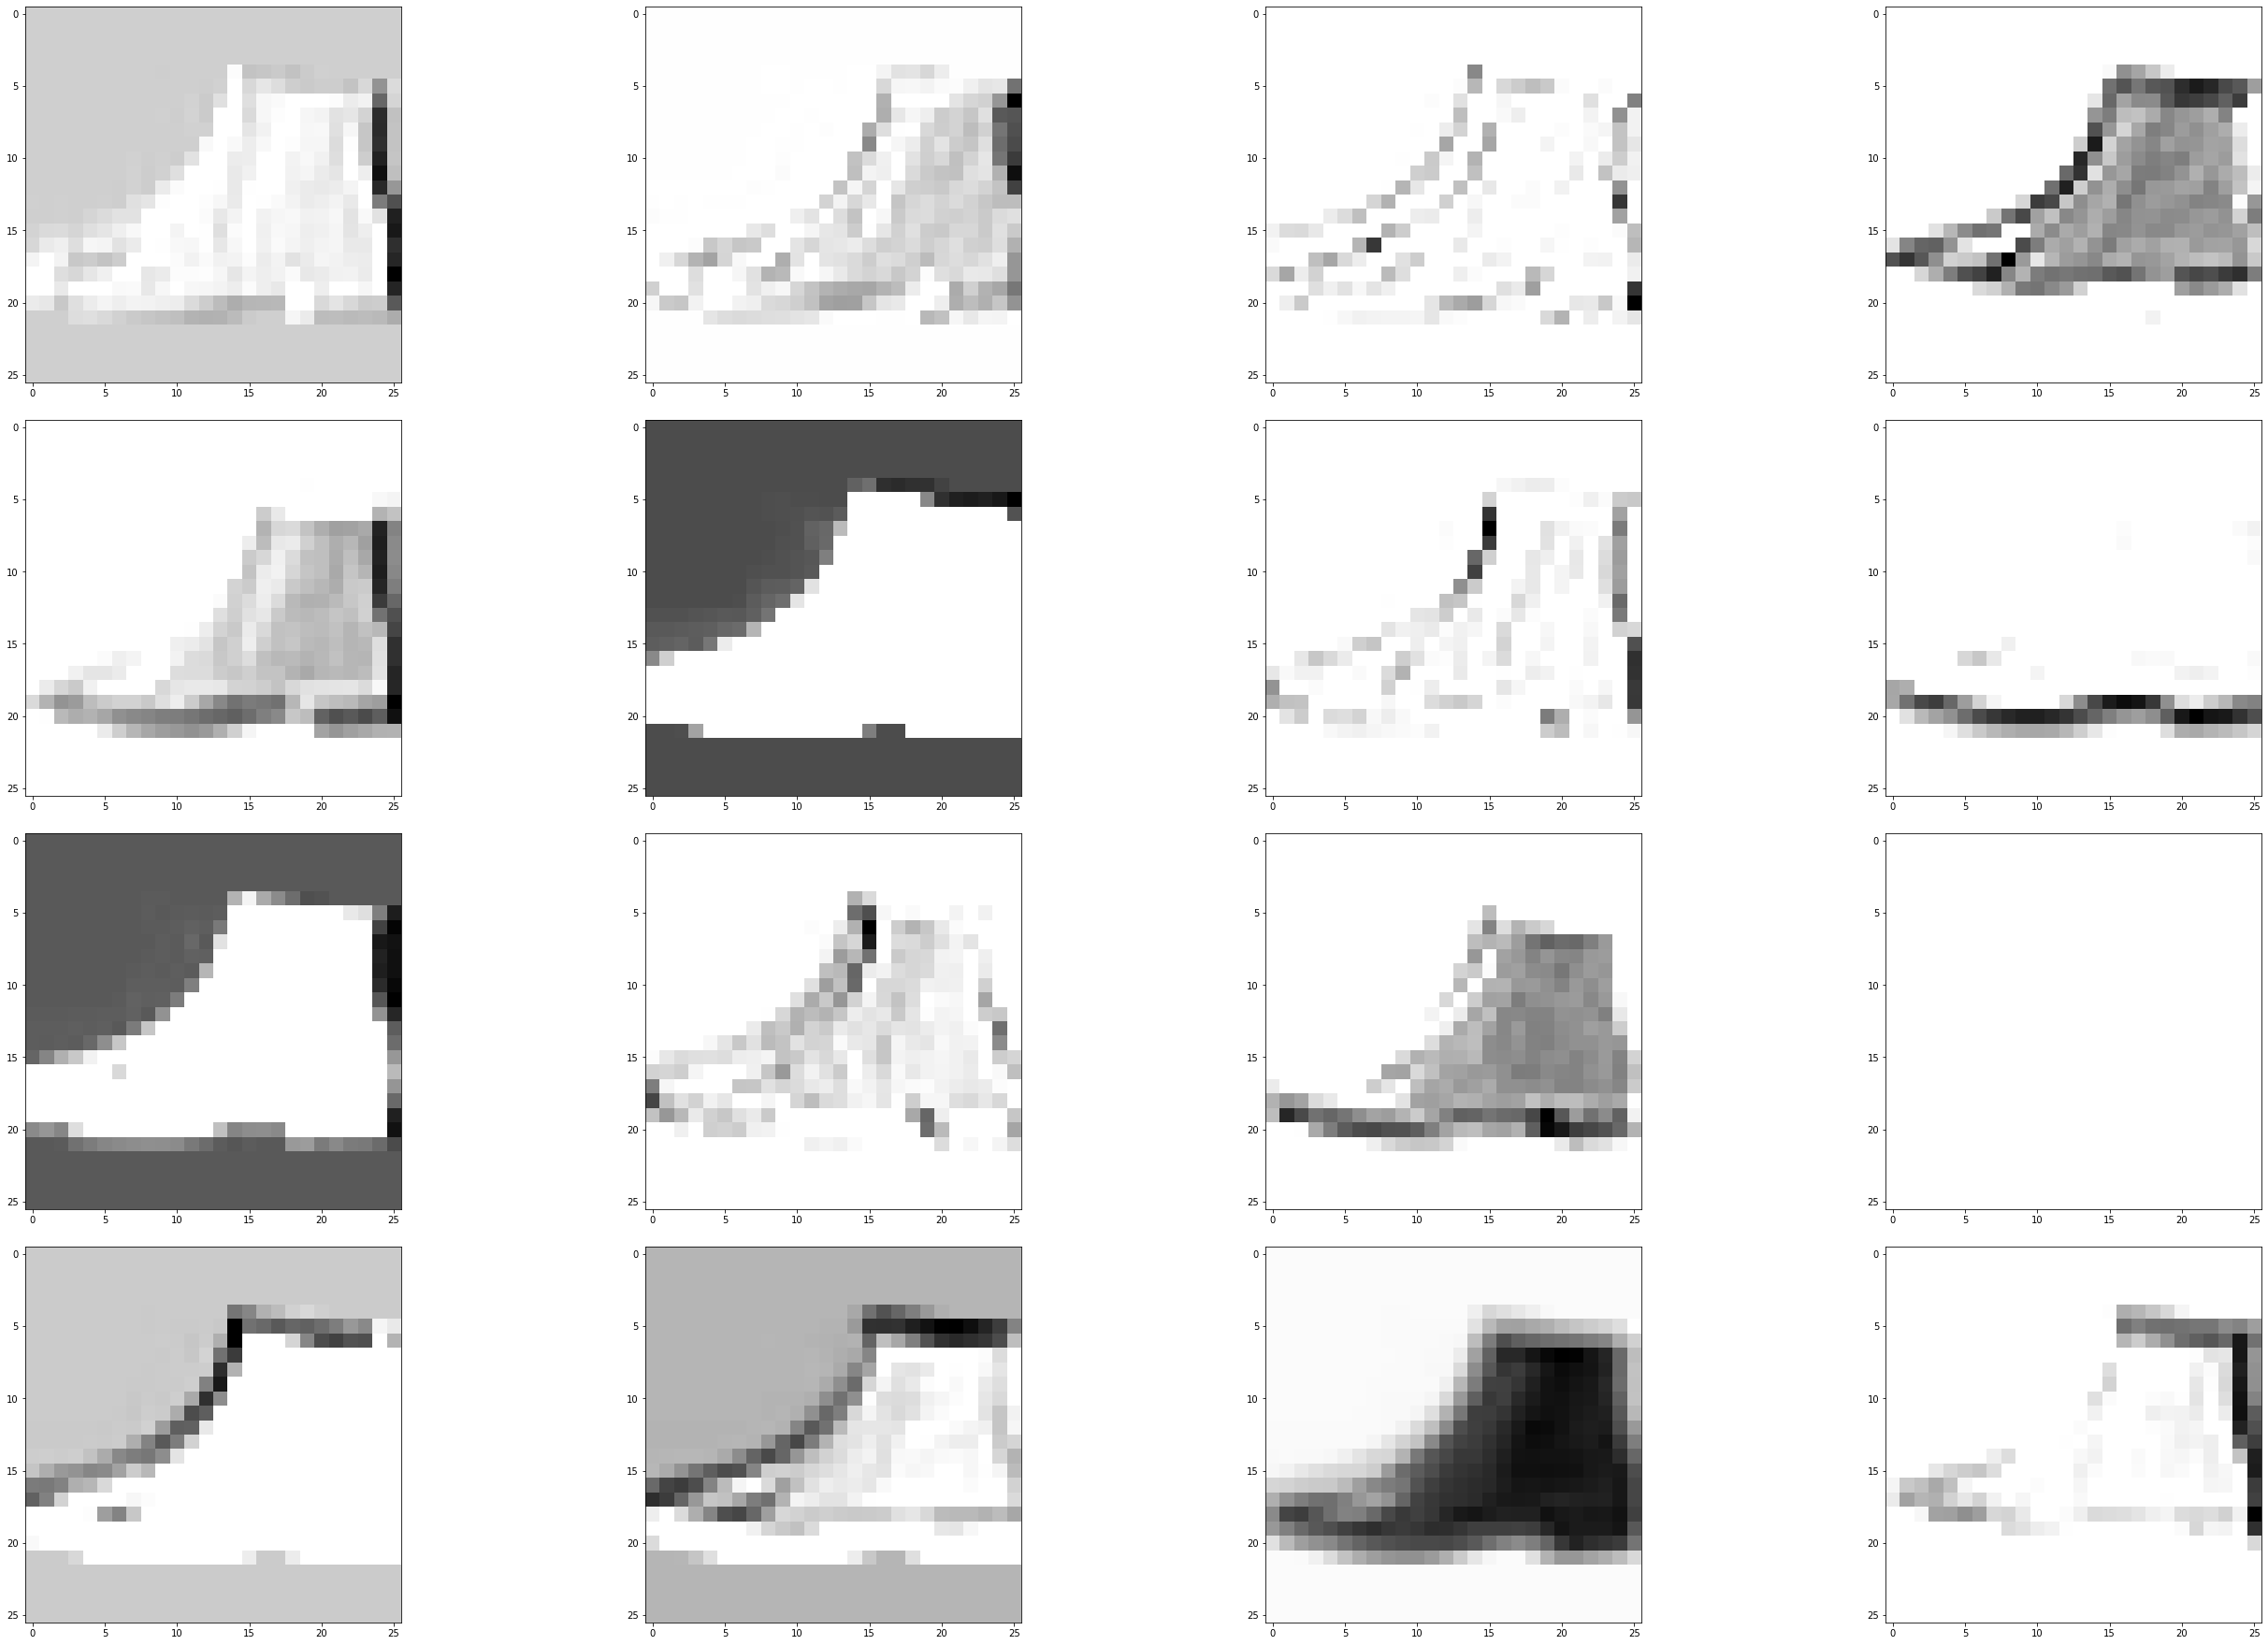

Layer  2


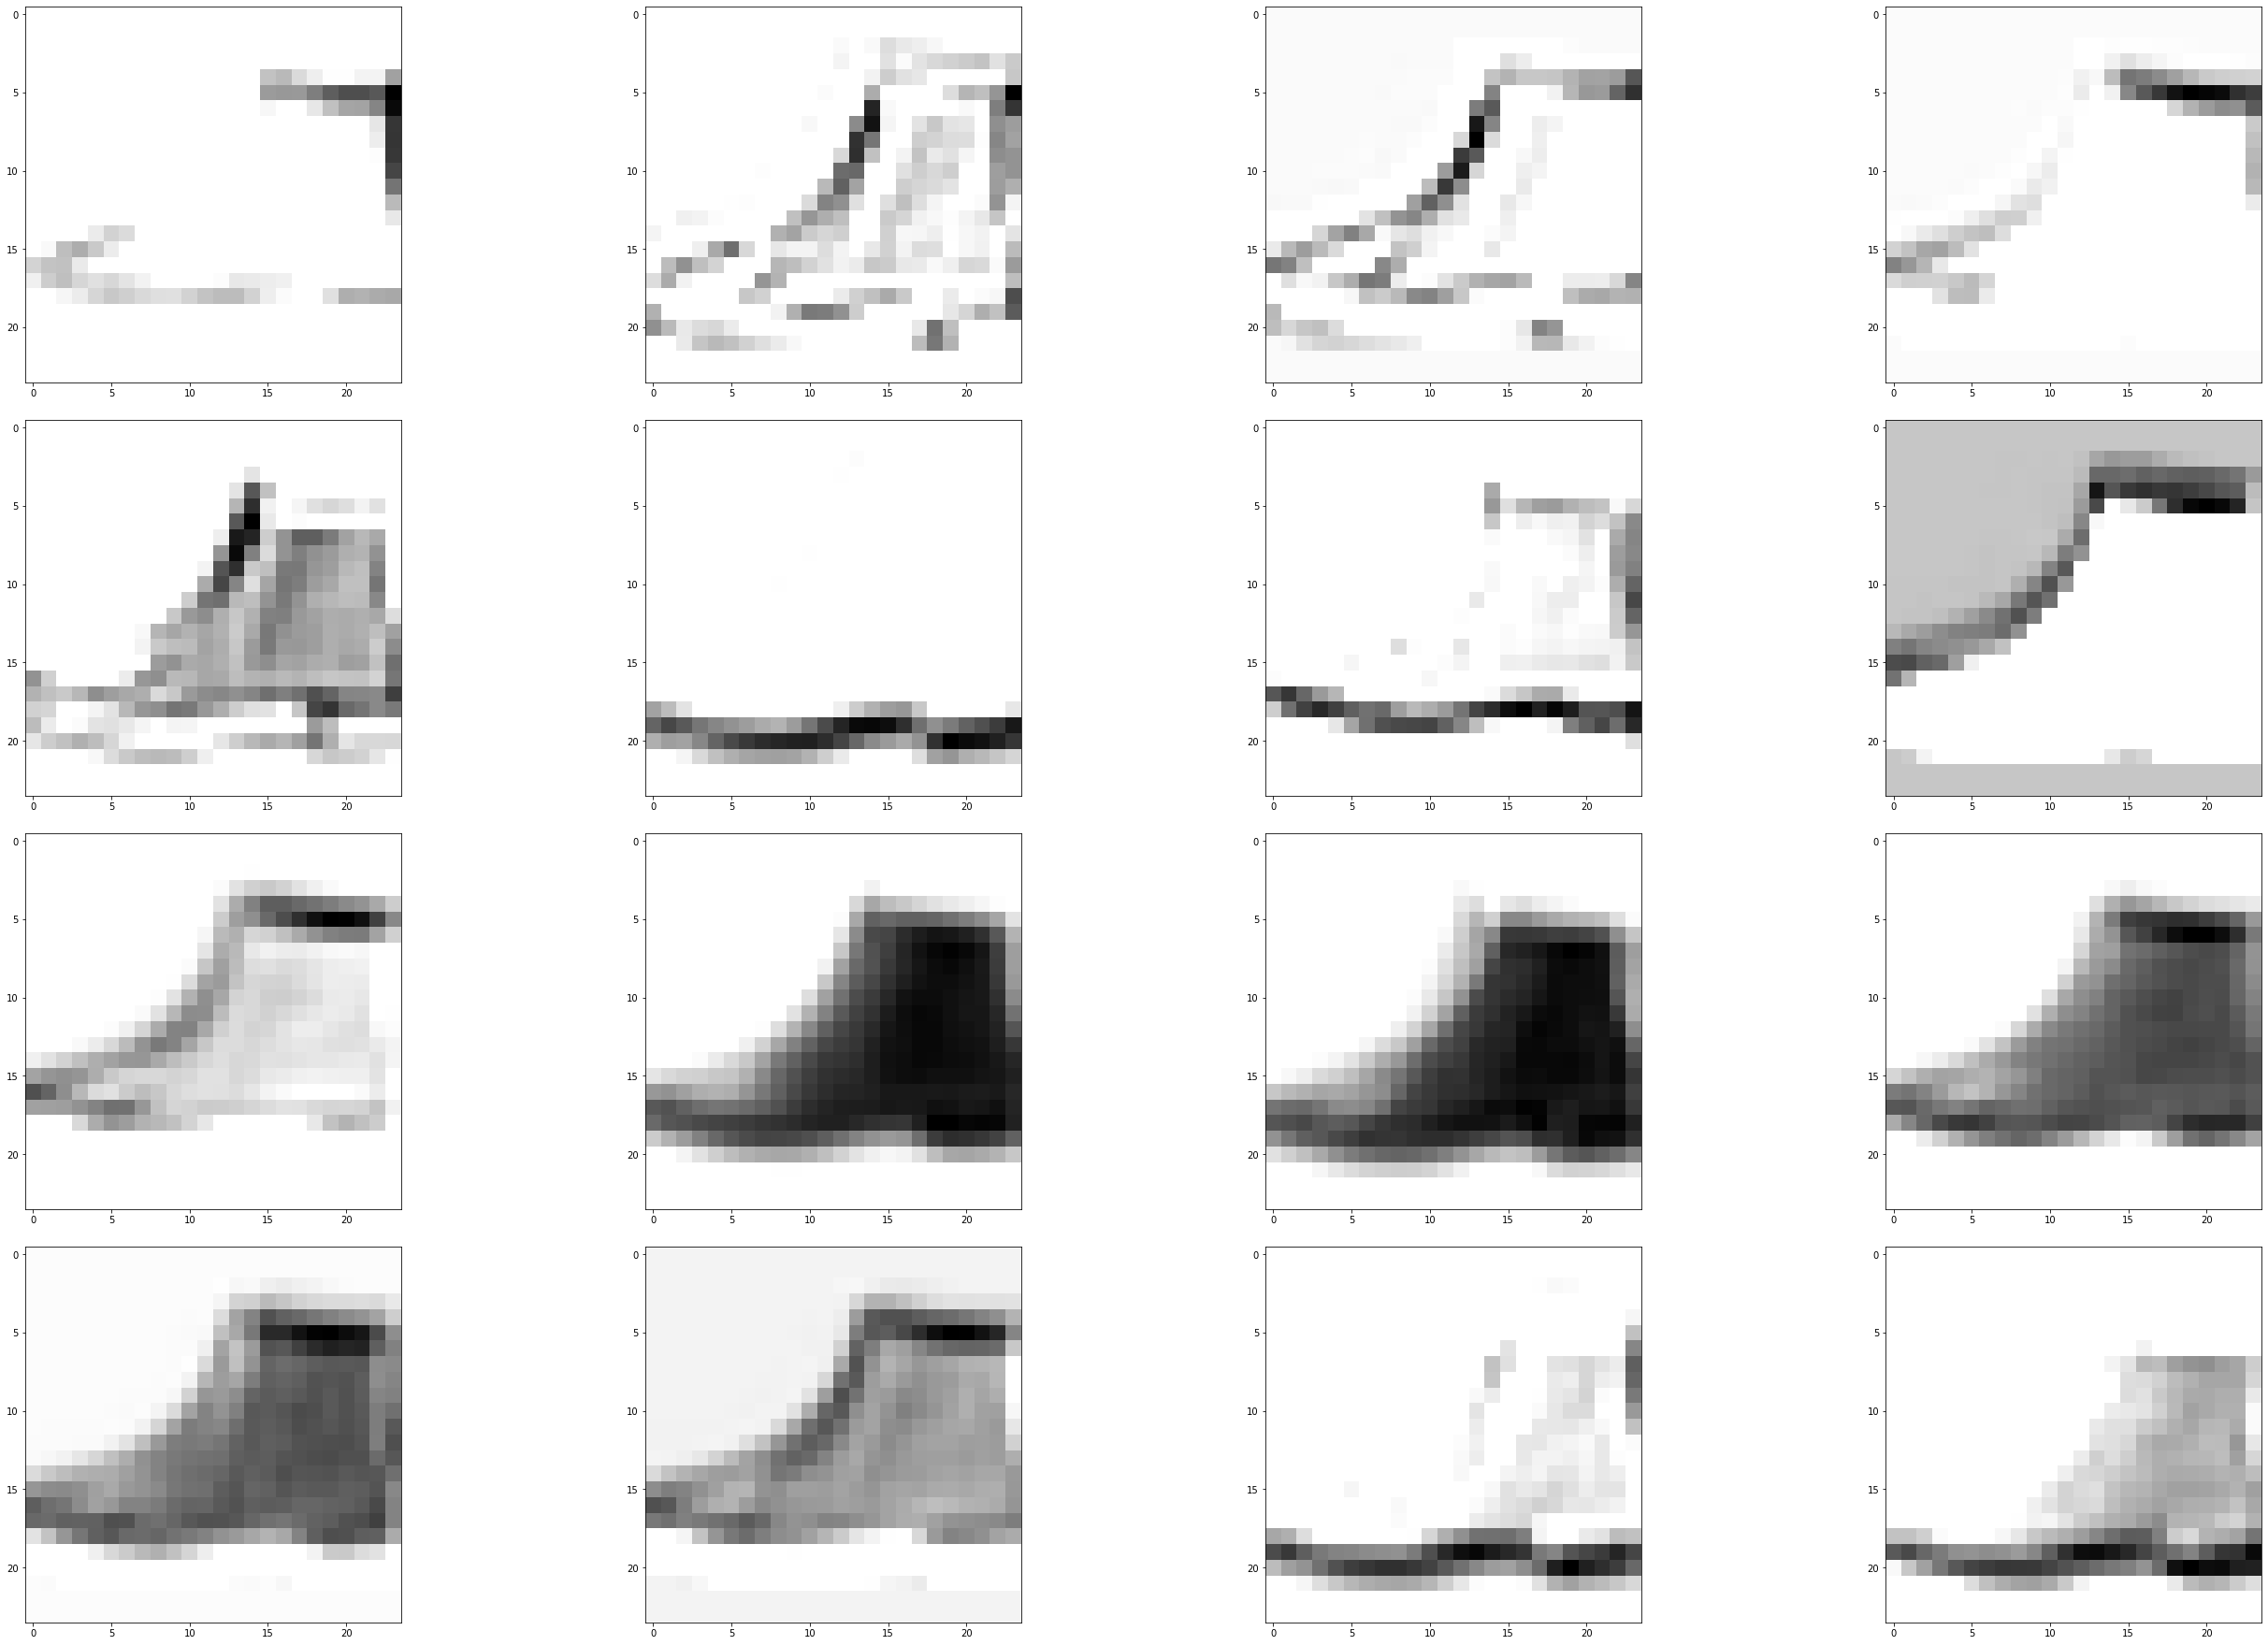

In [35]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(60, 30))
    fig.tight_layout()
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(4 ,4, i + 1)
        
        plt.imshow(torch.nn.functional.relu(filter).cpu().numpy(),cmap=plt.cm.binary)
       # plt.axis("off")
      
    plt.subplots_adjust(left=0.3,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.1) 
    plt.show()
    plt.close()

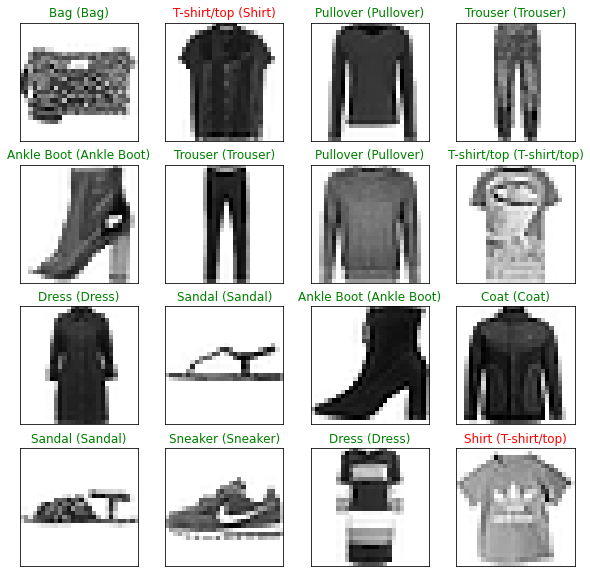

In [25]:
# classes of fashion mnist dataset
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
# creating iterator for iterating the dataset
dataiter = iter(test_loader)
images, labels = dataiter.next()
images=images.to(device)
labels=labels.to(device)

images_arr = []
labels_arr = []
pred_arr = []

for i in range(0,20):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.cpu().numpy().squeeze()
    pred_arr.append(np.argmax(ps))
# plotting the results
fig = plt.figure(figsize=(10,10))
# plt.title('predict/True')
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[i].resize_(1, 28, 28).cpu().numpy().squeeze(),cmap=plt.cm.binary)
    ax.set_title("{} ({})".format(classes[pred_arr[i]], classes[labels_arr[i]]),
                 color=("green" if pred_arr[i]==labels_arr[i] else "red"))
    


# vgg16

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
model.eval()
model.features[0] = nn.Conv2d(1,64,3,1,1)
model=model.cuda()
print(model)

In [ ]:
from torchvision import models
from torchsummary import summary
summary(model, (1, 32, 32))

# Resnet 18

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model=model.cuda()